# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

---

Looks at IV lead of 9 months, HO lag of 3 months forward

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

# iterating
import itertools

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
data_path = 'I:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\'

In [3]:
# decide whether to save results:
save_results = False
# decide whether to delete old dataframes from memory when we get to modeling
clean_memory = True

# Read in data

In [4]:
# read in our modeling data
# df = pd.read_parquet(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-9.parquet'))
# df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-13-top1.csv'))
# df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-13-top10.csv'))
# df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-14-top20.csv'))
# df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-17-top15_4tpy_ds_wind.csv'))
# df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-17-top50_4tpy_ds_wind.csv'))
# df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-17-top15_4tpy_ds_wind_ratios.csv'))
df = pd.read_csv(os.path.join(data_path, 'modeling_data\\modeling_data_joined_11-19-top20_4tpy_ds_wind_ratios_insts.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

# Data clean

In [5]:
def kde_multiple_plotter(col_list:list, title_str:str, value_name_str:str, df_plot, clip_tuple:tuple = None, log_scale_value=False):
    """plots several KDE plots from column of a dataframe.

    Args:
        col_list (list): list of columns to plot, must be in df_plot
        title_str (str): title of plot
        value_name_str (str): x axis value name
        df_plot (pandas dataframe): dataframe
        clip_tuple (tuple, optional): range of x axis values to plot. Defaults to None.
    """

    if log_scale_value:
        s = '(Log)'
    else:
        s = ''

    df_melt = pd.melt(df_plot, 
              value_vars=col_list, 
              var_name='measure', value_name=value_name_str)
    sns.set(rc = {'figure.figsize':(15,4)}) 
    sns.set_style("whitegrid", {'axes.grid' : False})

    sns.kdeplot(data=df_melt, x=value_name_str, hue='measure', bw_adjust=.8, fill=True, clip=clip_tuple, log_scale=log_scale_value)\
    .set_title(title_str+s, size=20)
    print('')


In [6]:
def filter_nans(df, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents',
       'visits_type_1_diabetes', 'visits_pediatric_vasculitis',
       'visits_resp_cardio']):
    """Function to generate columns in place that replace NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # check the school zip first
        if dataset_row_idx < first_val_row_idx:
            orig_visits = orig_visits
        elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
            if pd.isnull(orig_visits):
                orig_visits = 0
            else:
                orig_visits = orig_visits
        return orig_visits
        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    #df_grouped_schools['points_rank'] = df.groupby(['team'])['points'].rank('dense', ascending=False)
    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]
            #display(temp)
            #temp['rowIndex'] = temp.apply(get_rowIndex, axis=1)
            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            #display(visits_series)
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set valye to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

In [7]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
if isinstance(df.year_month[0], str):
  # if year month is still a string, convert it to datetime
  # don't try if already converted
    df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]

df.sort_values(['school_zip', 'year_month'], inplace=True)

df = filter_nans(df, visits_cols = ['number_of_visits_hem_cancers', 'number_of_visits_vasc', 
'number_of_visits_diab', 'number_of_visits_resp_cardio', 'number_of_visits_injuries'])


# for var in med_vars:
#     df[var] = df[var].fillna(0)


# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])
df['pm25_last_month_log'] = np.log1p(df['pm25_last_month'])
df['pm25_r6_log'] = np.log1p(df['pm25_r6'])
df['pm25_r9_log'] = np.log1p(df['pm25_r9'])
df['pm25_r12_log'] = np.log1p(df['pm25_r12'])


# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just directly use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

Generate lag windows for our outcomes.

Lag window includes the current month we are inspecting. These will be used to form our health outcomes for stage 2.

As of this notebook, for our windows are for:

```
med_vars = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]
```

For each of the health outcomes, produce columns for the following lag windows:

- 3 months
- 6 months
- 12 months

This is using the current month as the starting month

In [8]:
# make sure the df is sorted
df = df.sort_values(['school_zip', 'year_month'])

df.head(5)

,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v1_unnormed_wspd_ratio,Izmy_v2_nodist_unnormed,Izmy_v2_nodist_unnormed_wspd_ratio,Izmy_v3_normed_D_and_TPY,Izmy_v3_normed_D_and_TPY_wspd_ratio,Izmy_v4_nodist_normed_TPY,Izmy_v4_nodist_normed_TPY_wspd_ratio,Izmy_v5_all_normed,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,zip_year_month,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab,resp_cardio,number_of_visits_resp_cardio,injuries_accidents,number_of_visits_injuries,y_hematopoietic,y_vasculitis,y_diabetes,y_resp_cardio,y_injuries,pm25_log,pm25_last_month_log,pm25_r6_log,pm25_r9_log,pm25_r12_log,year_trend,county_month,year_month_county
0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
df['avg_wspd_top_20'].min()

1.0657277962701612

In [10]:
# get rolling n month avg

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df`: returns dataframe with column added
  """

  # df_temp = df[['year_month', 'school_zip', var_name]].copy(deep=True)
  
  ### Doesn't work
  # df[f'{var_name}_fwd{num_months}'] = df_temp.set_index('year_month')\
  #                                     .groupby(['school_zip'])[var_name]\
  #                                     .apply(lambda x: x.asfreq('1MS').rolling(num_months).sum().shift(1-num_months))\
  #                                       .reset_index()[var_name]

  if center_arg:
    df[f'{var_name}_cent{num_months}'] = df.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df[f'{var_name}_fwd{num_months}'] = df.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  ### Doesn't work
  # df = pd.merge(df, df_temp.set_index('year_month')\
  #   .groupby(['school_zip'])[var_name]\
  #       .apply(lambda x: x.asfreq('1M').rolling(num_months).sum().shift(1-num_months)).reset_index(),\
  #           on=['year_month', 'school_zip']).rename(columns={'{var_name}_x': '{var_name}', '{var_name}_y': '{var_name}_fwd{num_months}'})  
  
  return df 

In [11]:
df_2 = df[df['year_month'] < '2018-01-01']

In [13]:
df_2.head(10)

,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,zip_year_month,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab,resp_cardio,number_of_visits_resp_cardio,injuries_accidents,number_of_visits_injuries,y_hematopoietic,y_vasculitis,y_diabetes,y_resp_cardio,y_injuries,pm25_log,pm25_last_month_log,pm25_r6_log,pm25_r9_log,pm25_r12_log,year_trend,county_month,year_month_county
0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,Na

In [12]:
# make rolling sum columns

df_2 = df_2.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_2.columns)

num_visits_col_names = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]

y_col_names = ['y_hematopoietic', 
  'y_vasculitis', 
  'y_diabetes',
  'y_resp_cardio',
  'y_injuries'
  ]


# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


# print columns added
ending_cols = list(df_2.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 3 month window:\n{window_3months_columns}")
starting_cols = list(df_2.columns)


# 6 months ---
n = 6

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


# print columns added
ending_cols = list(df_2.columns)
window_6months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 6 month window:\n{window_6months_columns}")
starting_cols = list(df_2.columns)


# 12 months ---
n = 12

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


ending_cols = list(df_2.columns)
window_12months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 12 month window:\n{window_12months_columns}")
starting_cols = list(df_2.columns)


Columns added for health outcomes using 3 month window:
['number_of_visits_hem_cancers_fwd3', 'y_hematopoietic_fwd3', 'number_of_visits_hem_cancers_cent3', 'y_hematopoietic_cent3', 'number_of_visits_vasc_fwd3', 'y_vasculitis_fwd3', 'number_of_visits_vasc_cent3', 'y_vasculitis_cent3', 'number_of_visits_diab_fwd3', 'y_diabetes_fwd3', 'number_of_visits_diab_cent3', 'y_diabetes_cent3', 'number_of_visits_resp_cardio_fwd3', 'y_resp_cardio_fwd3', 'number_of_visits_resp_cardio_cent3', 'y_resp_cardio_cent3', 'number_of_visits_injuries_fwd3', 'y_injuries_fwd3', 'number_of_visits_injuries_cent3', 'y_injuries_cent3']

Columns added for health outcomes using 6 month window:
['number_of_visits_hem_cancers_fwd6', 'y_hematopoietic_fwd6', 'number_of_visits_hem_cancers_cent6', 'y_hematopoietic_cent6', 'number_of_visits_vasc_fwd6', 'y_vasculitis_fwd6', 'number_of_visits_vasc_cent6', 'y_vasculitis_cent6', 'number_of_visits_diab_fwd6', 'y_diabetes_fwd6', 'number_of_visits_diab_cent6', 'y_diabetes_cent6', 

In [13]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [1, 6, 9, 12]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    df_int = df_int.sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = [1, 6, 9, 12]

        for period in rolling_periods:
            df_int = df_int.sort_values(['school_zip', 'year_month'])
            
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int

In [16]:
df_2.head()

,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,zip_year_month,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab,resp_cardio,number_of_visits_resp_cardio,injuries_accidents,number_of_visits_injuries,y_hematopoietic,y_vasculitis,y_diabetes,y_resp_cardio,y_injuries,pm25_log,pm25_last_month_log,pm25_r6_log,pm25_r9_log,pm25_r12_log,year_trend,county_month,year_month_county,number_of_visits_hem_cancers_fwd3,y_hematopoietic_fwd3,number_of_visits_hem_cancers_cent3,y_hematopoietic_cent3,number_of_visits_vasc_fwd3,y_vasculitis_fwd3,number_of_visits_vasc_cent3,y_vasculitis_cent3,number_of_visits_diab_fwd3,y_diabetes_fwd3,number_of_visits_diab_cent3,y_diabetes_cent3,number_of_visits_resp_cardio_fwd3,y_resp_cardio_fwd3,number_of_visits_resp_cardio_cent3,y_resp_cardio_cent3,number_of_visits_injuries_fwd3,y_injuries_fwd3,number_of_visits_injuries_cent3,y_injuries_cent3,number_of_visits_hem_cancers_fwd6,y_hematopoietic_fwd6,number_of_visits_hem_cancers_cent6,y_hema

In [255]:
df_2.columns.tolist()

['Unnamed: 0',
 'year_month',
 'school_zip',
 'school_county_v2',
 'school_region_name',
 'pm25',
 'school_elevation_m',
 'ps_elevation_m',
 'population_0_4',
 'population_0_4_male',
 'population_0_4_female',
 'population_5_9',
 'population_5_9_male',
 'population_5_9_female',
 'population_10_14',
 'population_10_14_male',
 'population_10_14_female',
 'population_15_19',
 'population_15_19_male',
 'population_15_19_female',
 'total_pop_under19',
 'pop_under19_male',
 'pop_under19_female',
 'total_population',
 'total_population_male',
 'total_population_female',
 'point_source_pm25_tpy',
 'dist_school_to_ps_m',
 'angle_to_school',
 'ps_wspd_merge',
 'school_wdir_wrt_0n',
 'ps_wdir_wrt_0n',
 'school_wind_alignment',
 'ps_wind_alignment',
 'avg_wind_speed',
 'avg_wind_alignment',
 'avg_wind_alignment_cosine',
 'nearby_point_source_count',
 'school_wspd',
 'ca_agi_per_returns',
 'total_tax_liability',
 'tax_liability_per_capita',
 'school_temperature',
 'ps_temperature',
 'school_count',


In [14]:
cols_to_roll = ['central_wind_alignment_180_high',
                'Izmy_v1_unnormed',
                'Izmy_v1_unnormed_wspd_ratio',
                'Izmy_v2_nodist_unnormed',
                'Izmy_v2_nodist_unnormed_wspd_ratio',
                'Izmy_v3_normed_D_and_TPY',
                'Izmy_v3_normed_D_and_TPY_wspd_ratio',
                'Izmy_v4_nodist_normed_TPY',
                'Izmy_v4_nodist_normed_TPY_wspd_ratio',
                'Izmy_v5_all_normed',
                'Izmy_v5_all_normed_but_wspd_ratio',
                'Izmy_v6_unnormed_no_wspd',
                'Izmy_v7_all_normed_no_wspd',
                'Izmy_v8_normed_D_and_TPY_no_wspd',
                'avg_wspd_top_20',
                'avg_school_wspd',
                'avg_ps_wspd',
                'new_alignment_90_high',
                'school_temperature',
                'ps_temperature',
                'avg_temp',
                'avg_wspd_ratio_ps_sch',
                'avg_wspd_ratio_sch_ps'
               ]

rolling_periods = [9]

df_2 = df_2.sort_values(['school_zip', 'year_month'])

df_2, all_cols = roll_selected_cols(df=df_2, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

In [15]:
# for col in cols_to_roll:
#     if col[-6:] == '_log10':
#         print(col,"is log-transformed.")
#     else:
#         print(col,"is not log-transformed.")

Izmy_v1_unnormed is not log-transformed.
Izmy_v2_nodist_unnormed is not log-transformed.
Izmy_v3_normed_D_and_TPY is not log-transformed.
Izmy_v4_nodist_normed_TPY is not log-transformed.
Izmy_v5_all_normed is not log-transformed.
central_wind_alignment_180_high is not log-transformed.
Izmy_v1_unnormed_log10 is log-transformed.
Izmy_v2_nodist_unnormed_log10 is log-transformed.
Izmy_v3_normed_D_and_TPY_log10 is log-transformed.
Izmy_v4_nodist_normed_TPY_log10 is log-transformed.
Izmy_v5_all_normed_log10 is log-transformed.


In [16]:
df_2.shape

(294897, 274)

In [15]:
df_3 = df_2[df_2['year_month'] > '2001-12-31']

In [116]:
df_3.shape

(262674, 280)

In [20]:
df_3.columns.tolist()

['Unnamed: 0',
 'year_month',
 'school_zip',
 'school_county_v2',
 'school_region_name',
 'pm25',
 'school_elevation_m',
 'ps_elevation_m',
 'population_0_4',
 'population_0_4_male',
 'population_0_4_female',
 'population_5_9',
 'population_5_9_male',
 'population_5_9_female',
 'population_10_14',
 'population_10_14_male',
 'population_10_14_female',
 'population_15_19',
 'population_15_19_male',
 'population_15_19_female',
 'total_pop_under19',
 'pop_under19_male',
 'pop_under19_female',
 'total_population',
 'total_population_male',
 'total_population_female',
 'point_source_pm25_tpy',
 'dist_school_to_ps_m',
 'angle_to_school',
 'ps_wspd_merge',
 'school_wdir_wrt_0n',
 'ps_wdir_wrt_0n',
 'school_wind_alignment',
 'ps_wind_alignment',
 'avg_wind_speed',
 'avg_wind_alignment',
 'avg_wind_alignment_cosine',
 'nearby_point_source_count',
 'school_wspd',
 'ca_agi_per_returns',
 'total_tax_liability',
 'tax_liability_per_capita',
 'school_temperature',
 'ps_temperature',
 'school_count',


# First stage regression - Predict pm2.5 levels

In [16]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

In [22]:
# our new input variables

# set this for which instrument number you want to use
which_instrument = 2

stage_1_targets = ['pm25', 'pm25_last_month', 'pm25_r6', 'pm25_r9', 'pm25_r12']

stage_1_predictor_angles = all_cols[which_instrument - 1]

stage1_io_df = pd.DataFrame()

stage1_io_df['stage_1_targets'] = stage_1_targets
stage1_io_df['stage_1_predictor_angles'] = stage_1_predictor_angles

print("This is a mapping of targets and instrumental variable predictors we can use for stage 1:\n")

display(stage1_io_df)

This is a mapping of targets and instrumental variable predictors we can use for stage 1:



,stage_1_targets,stage_1_predictor_angles
0,pm25,Izmy_v2_nodist_unnormed
1,pm25_last_month,Izmy_v2_nodist_unnormed_r1
2,pm25_r6,Izmy_v2_nodist_unnormed_r6
3,pm25_r9,Izmy_v2_nodist_unnormed_r9
4,pm25_r12,Izmy_v2_nodist_unnormed_r12


In [20]:
# include wind speeds for the same lead window as these below, if using:

# cols_to_roll = ['central_wind_alignment_180_high',
#                 'Izmy_v6_unnormed_no_wspd',
#                 'Izmy_v7_all_normed_no_wspd',
#                'Izmy_v8_normed_D_and_TPY_no_wspd',
#                 'new_alignment_90_high']

# do NOT include wind speeds for these:
# cols_to_roll = ['Izmy_v1_unnormed',
#                 'Izmy_v2_nodist_unnormed',
#                 'Izmy_v3_normed_D_and_TPY',
#                 'Izmy_v4_nodist_normed_TPY',
#                 'Izmy_v5_all_normed']

cols_to_roll = ['central_wind_alignment_180_high',
                 'new_alignment_90_high',
#                 'Izmy_v1_unnormed',
#                 'Izmy_v1_unnormed_wspd_ratio',
#                 'Izmy_v2_nodist_unnormed',
#                 'Izmy_v2_nodist_unnormed_wspd_ratio',
#                 'Izmy_v3_normed_D_and_TPY',
#                 'Izmy_v3_normed_D_and_TPY_wspd_ratio',
#                 'Izmy_v4_nodist_normed_TPY',
#                 'Izmy_v4_nodist_normed_TPY_wspd_ratio',
#                 'Izmy_v5_all_normed',
#                 'Izmy_v5_all_normed_but_wspd_ratio'
                 'Izmy_v6_unnormed_no_wspd',
                 'Izmy_v7_all_normed_no_wspd',
                 'Izmy_v8_normed_D_and_TPY_no_wspd'
                 ]

predictors = cols_to_roll
lead_times = [9]
lag_times = [3]
lag_styles = ['fwd']

iterations = list(itertools.product(predictors, lead_times, lag_times, lag_styles))
print(iterations)

[('central_wind_alignment_180_high', 9, 3, 'fwd'), ('new_alignment_90_high', 9, 3, 'fwd'), ('Izmy_v6_unnormed_no_wspd', 9, 3, 'fwd'), ('Izmy_v7_all_normed_no_wspd', 9, 3, 'fwd'), ('Izmy_v8_normed_D_and_TPY_no_wspd', 9, 3, 'fwd')]


## Stage 1 Alone

In [59]:
# spot testing 


# iterations = [('Izmy_v1_unnormed', 9, 3, 'fwd')]
# iterations = [('Izmy_v2_nodist_unnormed', 9, 3, 'fwd')]
iterations = [('Izmy_v3_normed_D_and_TPY', 9, 3, 'fwd')]


In [22]:
df_model = df_3
results_df = pd.DataFrame(columns=['base_instrument','is_logged','lead_time','lag_time','lag_style','variable', 'coef', 'p_value', '95_ci_lower', '95_ci_upper','r2'])

results_list = []

# rename for consistent use in loop
df_model.columns = ['pm25_r1' if x=='pm25_last_month' else x for x in df_model.columns]

print("-"*80)

for combination in iterations:
    predictor, lead_time, lag_time, lag_style = [*combination]

    # define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
    IV_lead = "r" + str(lead_time)
    HO_lag = lag_style + str(lag_time)

    if IV_lead:
        IV_lead_input = "_" + IV_lead 
    else:
        # don't add underscore if empty string
        IV_lead_input = IV_lead

    # define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
    if HO_lag:
        HO_lag_input = "_" + HO_lag 
    else:
        # don't add underscore if empty string
        HO_lag_input = HO_lag

    # IV options: 1 month, 6 months, 9 months, 12 months
    IV_window_col = [f'pm25{IV_lead_input}']

    # health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
    health_outcome_window_col = [f'y_injuries{HO_lag_input}']

#     filter_cols = IV_window_col + health_outcome_window_col
    filter_cols = IV_window_col

    df_model_temp = df_model.copy()
    df_model_temp = df_model_temp.dropna(subset=filter_cols)

    print("Now processing:",predictor,IV_lead, HO_lag,"...")

    
    # dropping population ones to avoid data leakage
    target_name_s1 = f'pm25{IV_lead_input}'
    # predictor_name_s1 = f'avg_wind_alignment_cosine{IV_lead_input}'
    predictor_name_s1 = f'{predictor}{IV_lead_input}'
    
    # version without wind speed
    
#     y, X = dmatrices(f'{target_name_s1} ~ {predictor_name_s1} + \
#       school_temperature + ps_temperature + \
#       school_county_v2 + month  + year_trend * C(county_month)', 
#       data=df_model_temp, return_type='dataframe')


    y, X = dmatrices(f'{target_name_s1} ~ {predictor_name_s1} + \
          avg_temp_r9 + avg_elevation_diff_m + avg_wspd_top_20_r9 +\
          school_county_v2 + month + year_trend * C(county_month)', \
          data=df_model_temp, return_type='dataframe')

    # + avg_school_wspd_r6 + avg_ps_wspd_r6
    
#     y, X = dmatrices(f'{target_name_s1} ~ {predictor_name_s1} + \
#       dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#       school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
#       school_county_v2 + month + year_trend * C(county_month)', 
#       data=df_model_temp, return_type='dataframe')

    # rearrange columns
    X = X[[predictor_name_s1] + [i for i in X.columns if not re.search(predictor_name_s1, i)]]

    # fit model
    fit1 = sm.OLS(y, X).fit()

    # add fitted y value to our dataset
    df_model_temp['yhat_pm25'] = fit1.fittedvalues.values

    # save model
    if save_results:
      fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

    # Get residuals
    resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

    # calculate r^2
    ss_resid = sum((df_model_temp['yhat_pm25'].values - df_model_temp[target_name_s1].values)**2)
    ss_total = sum((df_model_temp[target_name_s1].mean() - df_model_temp[target_name_s1].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    print("R squared =",r_squared)
    print("coeff =",get_ols_res(fit1).loc[0][1])
    print("p =",get_ols_res(fit1).loc[0][2])
    
    
    
    
    print("-"*80)
    print()
    
    ## new code to package up results for df output

    # update from 

    temp_df = pd.DataFrame(columns=['base_instrument','is_logged','lead_time','lag_time','lag_style','variable', 'coef', 'p_value', '95_ci_lower', '95_ci_upper','r2'])
    temp_df[get_ols_res(fit1).columns.tolist()] = pd.DataFrame([tuple(get_ols_res(fit1).loc[0])])
    
    is_logged = 'no'
    if predictor[-6:] == '_log10':
        is_logged = 'log10'
    
    cols_to_update = ['base_instrument','is_logged','lead_time','lag_time','lag_style','r2']
    col_values = (predictor, is_logged, lead_time, lag_time, lag_style, r_squared)

    temp_df[[cols_to_update]] = pd.DataFrame(col_values)

    results_list.append(temp_df)

results_df = pd.concat(results_list)

# un-rename so we don't screw anything else up
df_model.columns = ['pm25_last_month' if x=='pm25_r1' else x for x in df_model.columns]

--------------------------------------------------------------------------------
Now processing: central_wind_alignment_180_high r9 fwd3 ...


NameError: name 'save_results' is not defined

In [25]:
# combined, pseudo-automated full version test

df_model = df_3
results_df = pd.DataFrame(columns=['base_instrument','is_logged','lead_time','lag_time','lag_style','variable', 'coef', 'p_value', '95_ci_lower', '95_ci_upper','r2'])

results_list = []

# rename for consistent use in loop
df_model.columns = ['pm25_r1' if x=='pm25_last_month' else x for x in df_model.columns]

print("-"*80)

for combination in iterations:
    predictor, lead_time, lag_time, lag_style = [*combination]

    # define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
    IV_lead = "r" + str(lead_time)
    HO_lag = lag_style + str(lag_time)

    if IV_lead:
        IV_lead_input = "_" + IV_lead 
    else:
        # don't add underscore if empty string
        IV_lead_input = IV_lead

    # define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
    if HO_lag:
        HO_lag_input = "_" + HO_lag 
    else:
        # don't add underscore if empty string
        HO_lag_input = HO_lag

    # IV options: 1 month, 6 months, 9 months, 12 months
    IV_window_col = [f'pm25{IV_lead_input}']

    # health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
    health_outcome_window_col = [f'y_injuries{HO_lag_input}']

    filter_cols = IV_window_col + health_outcome_window_col
    df_model_temp = df_model.copy()
    df_model_temp = df_model_temp.dropna(subset=filter_cols)

    print("Now processing:",predictor,IV_lead, HO_lag,"...")

    
    # dropping population ones to avoid data leakage
    target_name_s1 = f'pm25{IV_lead_input}'
    # predictor_name_s1 = f'avg_wind_alignment_cosine{IV_lead_input}'
    predictor_name_s1 = f'{predictor}{IV_lead_input}'
    
    # version without wind speed

    y, X = dmatrices(f'{target_name_s1} ~ {predictor_name_s1} + \
          avg_temp_r9 + avg_elevation_diff_m + avg_wspd_ratio_ps_sch_r9 +\
          school_county_v2 + month + year_trend * C(county_month)', \
          data=df_model_temp, return_type='dataframe')

    # rearrange columns
    X = X[[predictor_name_s1] + [i for i in X.columns if not re.search(predictor_name_s1, i)]]

    # fit model
    fit1 = sm.OLS(y, X).fit()

    # add fitted y value to our dataset
    df_model_temp['yhat_pm25'] = fit1.fittedvalues.values

    # Get residuals
    resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

    # calculate r^2
    ss_resid = sum((df_model_temp['yhat_pm25'].values - df_model_temp[target_name_s1].values)**2)
    ss_total = sum((df_model_temp[target_name_s1].mean() - df_model_temp[target_name_s1].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    print("R squared =",r_squared)
    print("coeff =",get_ols_res(fit1).loc[0][1])
    print("p =",get_ols_res(fit1).loc[0][2])
    
    df_model = df_model_temp
    
    # drop instrument, and add x_hat to the X matrix
    X = X.drop(columns=predictor_name_s1)
    X['yhat_pm25'] = df_model['yhat_pm25']
    X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
    X_truepm25 = pd.concat([df_model[target_name_s1], X.drop(columns='yhat_pm25')], axis = 1)
    
    target_name_s2_hema = f'y_hematopoietic{HO_lag_input}'
    fit2_hema = sm.OLS(df_model[target_name_s2_hema], X).fit()
    df_model['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

    print('yhat pm2.5 hema',predictor)
    print(get_ols_res(fit2_hema).head(1))

    target_name_s2_vasc = f'y_vasculitis{HO_lag_input}'
    fit2_vasc = sm.OLS(df_model[target_name_s2_vasc], X).fit()
    df_model['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

    print('yhat pm2.5 vasculitis',predictor)
    print(get_ols_res(fit2_vasc).head(1))

    target_name_s2_diab = f'y_diabetes{HO_lag_input}'
    fit2_diab = sm.OLS(df_model[target_name_s2_diab], X).fit()
    df_model['yhat_diabetes'] = fit2_diab.fittedvalues.values

    print('yhat pm2.5 diabetes',predictor)
    print(get_ols_res(fit2_diab).head(1))

    target_name_s2_resp_cardio = f'y_resp_cardio{HO_lag_input}'
    fit2_resp_cardio = sm.OLS(df_model[target_name_s2_resp_cardio], X).fit()
    df_model['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

    print('yhat pm2.5 cardioresp',predictor)
    print(get_ols_res(fit2_resp_cardio).head(1))

    target_name_s2_injuries = f'y_injuries{HO_lag_input}'
    fit2_injuries = sm.OLS(df_model[target_name_s2_injuries], X).fit()
    df_model['yhat_injuries'] = fit2_injuries.fittedvalues.values

    print('yhat pm2.5 injuries',predictor)
    print(get_ols_res(fit2_injuries).head(1))
    
    print("-"*80)

# un-rename so we don't screw anything else up
df_model.columns = ['pm25_last_month' if x=='pm25_r1' else x for x in df_model.columns]

--------------------------------------------------------------------------------
Now processing: central_wind_alignment_180_high r9 fwd3 ...
R squared = 0.6977736477557903
coeff = -0.024039706964739237
p = 6.37689703169912e-135
yhat pm2.5 hema central_wind_alignment_180_high
    variable      coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.243593  0.00284     -0.40356    -0.083626
yhat pm2.5 vasculitis central_wind_alignment_180_high
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.066407  0.157507    -0.158487     0.025673
yhat pm2.5 diabetes central_wind_alignment_180_high
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.277522  0.159989    -0.664634      0.10959
yhat pm2.5 cardioresp central_wind_alignment_180_high
    variable       coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -12.963603  0.408397   -43.697531    17.770325
yhat pm2.5 injuries central_wind_alignment_180_high
    variable       coef   p_value  95_ci

In [ ]:
# true pm2.5 coeffs etc

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df_model[target_name_s2_hema], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

# fit model with true pm2.5
fit2_vasc_truepm25 = sm.OLS(df_model[target_name_s2_vasc], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm25).head(1))

# fit model with true pm2.5
fit2_diab_truepm25 = sm.OLS(df_model[target_name_s2_diab], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm25).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm25 = sm.OLS(df_model[target_name_s2_resp_cardio], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm25).head(1))

# fit model with true pm2.5
fit2_injuries_truepm25 = sm.OLS(df_model[target_name_s2_injuries], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm25).head(1))

In [ ]:
df_model = df_model_temp

In [272]:
df_model.columns.tolist()

['Unnamed: 0',
 'year_month',
 'school_zip',
 'school_county_v2',
 'school_region_name',
 'pm25',
 'school_elevation_m',
 'ps_elevation_m',
 'population_0_4',
 'population_0_4_male',
 'population_0_4_female',
 'population_5_9',
 'population_5_9_male',
 'population_5_9_female',
 'population_10_14',
 'population_10_14_male',
 'population_10_14_female',
 'population_15_19',
 'population_15_19_male',
 'population_15_19_female',
 'total_pop_under19',
 'pop_under19_male',
 'pop_under19_female',
 'total_population',
 'total_population_male',
 'total_population_female',
 'point_source_pm25_tpy',
 'dist_school_to_ps_m',
 'angle_to_school',
 'ps_wspd_merge',
 'school_wdir_wrt_0n',
 'ps_wdir_wrt_0n',
 'school_wind_alignment',
 'ps_wind_alignment',
 'avg_wind_speed',
 'avg_wind_alignment',
 'avg_wind_alignment_cosine',
 'nearby_point_source_count',
 'school_wspd',
 'ca_agi_per_returns',
 'total_tax_liability',
 'tax_liability_per_capita',
 'school_temperature',
 'ps_temperature',
 'school_count',


In [ ]:
display(results_df)

In [26]:
results_df.to_parquet(os.path.join(data_path, 'rolling_window_tests/first_output_stats.parquet'))

In [ ]:
temp_df = pd.DataFrame(columns=['base_instrument','is_logged','lead_time','lag_time','lag_style','variable', 'coef', 'p_value', '95_ci_lower', '95_ci_upper','r2'])
temp_df[get_ols_res(fit1).columns.tolist()] = pd.DataFrame([tuple(get_ols_res(fit1).loc[0])])

In [ ]:
display(temp_df)

In [ ]:
pd.DataFrame(tuple(get_ols_res(fit1).loc[0]))

In [ ]:
get_ols_res(fit1).loc[0][1]

In [ ]:
get_ols_res(fit1)

In [ ]:
is_logged = 'no'
if predictor[-6:] == '_log10':
    is_logged = 'log10'

cols_to_update = ['base_instrument','is_logged','lead_time','lag_time','lag_style','r2']
col_values = (predictor, is_logged, lead_time, lag_time, lag_style, r_squared)

temp_df[[cols_to_update]] = pd.DataFrame(col_values)

results_list.append(temp_df)

In [ ]:
results_list[-1]

In [ ]:
print(results_list)

In [ ]:
display(results_df)

In [ ]:
new_df = pd.DataFrame(columns=['base_instrument','norming','lead_time','lag_time','lag_style','variable', 'coef', 'p_value', '95_ci_lower', '95_ci_upper','r2', 'is_logged'])

In [ ]:
new_df[get_ols_res(fit1).columns.tolist()] = pd.DataFrame([(get_ols_res(fit1).loc[0])])

In [ ]:
get_ols_res(fit1).columns.tolist()

In [ ]:
tuple(get_ols_res(fit1).loc[0])

In [ ]:
display(new_df)

In [ ]:
cols_to_update = ['base_instrument','norming','lead_time','lag_time','lag_style','r2', 'is_logged']

In [ ]:
is_logged = 'no'
if predictor[-6:] == '_log10':
    is_logged = 'log10'

In [ ]:
col_values = (predictor, is_logged, lead_time, lag_time, lag_style, r_squared, is_logged)

In [ ]:
new_df[[cols_to_update]] = pd.DataFrame(col_values)

In [ ]:
display(new_df)

In [ ]:
# calculate r^2
ss_resid = sum((df_model['yhat_pm25'].values - df_model[target_name_s1].values)**2)
ss_total = sum((df_model[target_name_s1].mean() - df_model[target_name_s1].values)**2)
r_squared = 1 - ss_resid / ss_total 

In [ ]:
r_squared

In [ ]:
get_ols_res(fit1).columns.tolist()

In [ ]:
temp_results = get_ols_res(fit1).loc[0]
# temp_results['r2'] = r_squared

# temp_results[['base_instrument','norming','lead_time','lag_time','lag_style']] = pd.DataFrame([[lead_predictor, 'unnormed', lead_time, lag_time, lag_style]])

In [ ]:
display(temp_results)

In [ ]:
display(new_df)

In [ ]:
new_df = new_df.append(temp_results)

In [ ]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

In [143]:
df_model.columns.tolist()

['Unnamed: 0',
 'year_month',
 'school_zip',
 'school_county_v2',
 'school_region_name',
 'pm25',
 'school_elevation_m',
 'ps_elevation_m',
 'population_0_4',
 'population_0_4_male',
 'population_0_4_female',
 'population_5_9',
 'population_5_9_male',
 'population_5_9_female',
 'population_10_14',
 'population_10_14_male',
 'population_10_14_female',
 'population_15_19',
 'population_15_19_male',
 'population_15_19_female',
 'total_pop_under19',
 'pop_under19_male',
 'pop_under19_female',
 'total_population',
 'total_population_male',
 'total_population_female',
 'point_source_pm25_tpy',
 'dist_school_to_ps_m',
 'angle_to_school',
 'ps_wspd_merge',
 'school_wdir_wrt_0n',
 'ps_wdir_wrt_0n',
 'school_wind_alignment',
 'ps_wind_alignment',
 'avg_wind_speed',
 'avg_wind_alignment',
 'avg_wind_alignment_cosine',
 'nearby_point_source_count',
 'school_wspd',
 'ca_agi_per_returns',
 'total_tax_liability',
 'tax_liability_per_capita',
 'school_temperature',
 'ps_temperature',
 'school_count',


# Second Stage Regression (New)

- Stage 1 of the least squares regression: $\widehat{PM}_{2.5}=\beta_0 + \beta_1 \theta_{downstream} + \beta_{2}year + \beta_{3}month + \beta_{4}county + \epsilon$
  - $\theta_{downstream}$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 

- Stage 2 of the equation: $Y=\frac{\sum diagnoses}{Pop_{zipcode, 0-19}}=\delta_0 + \delta_1 \widehat{PM}_{2.5} + \delta_{2}year + \delta_{3}month + \delta_{4}county + \epsilon$


In addition to this two stage framework, also run the stage 2 regression using true pm2.5 values. So we can see how biased the coefficient is. 

In [62]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns=predictor_name_s1)
X['yhat_pm25'] = df_model['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
X_truepm25 = pd.concat([df_model[target_name_s1], X.drop(columns='yhat_pm25')], axis = 1)

In [ ]:
# automation in progress

target_name_s2_hema = f'y_hematopoietic{HO_lag_input}'
fit2_hema = sm.OLS(df_model[target_name_s2_hema], X).fit()
df_model['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df_model[target_name_s2_hema], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

____

target_name_s2_vasc = f'y_vasculitis{HO_lag_input}'
fit2_vasc = sm.OLS(df_model[target_name_s2_vasc], X).fit()
df_model['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm25 = sm.OLS(df_model[target_name_s2_vasc], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm25).head(1))

____

target_name_s2_diab = f'y_diabetes{HO_lag_input}'
fit2_diab = sm.OLS(df_model[target_name_s2_diab], X).fit()
df_model['yhat_diabetes'] = fit2_diab.fittedvalues.values

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm25 = sm.OLS(df_model[target_name_s2_diab], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm25).head(1))

____

target_name_s2_resp_cardio = f'y_resp_cardio{HO_lag_input}'
fit2_resp_cardio = sm.OLS(df_model[target_name_s2_resp_cardio], X).fit()
df_model['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm25 = sm.OLS(df_model[target_name_s2_resp_cardio], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm25).head(1))

___


target_name_s2_injuries = f'y_injuries{HO_lag_input}'
fit2_injuries = sm.OLS(df_model[target_name_s2_injuries], X).fit()
df_model['yhat_injuries'] = fit2_injuries.fittedvalues.values

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm25 = sm.OLS(df_model[target_name_s2_injuries], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm25).head(1))

___

In [63]:
target_name_s2_hema = f'y_hematopoietic{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


# fit model
fit2_hema = sm.OLS(df_model[target_name_s2_hema], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(fitted_models_path, 'stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df_model[target_name_s2_hema], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.205475  0.019643     0.032862     0.378088

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -0.009589  0.012283    -0.017095    -0.002083


In [64]:
target_name_s2_vasc = f'y_vasculitis{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")

# fit model
fit2_vasc = sm.OLS(df_model[target_name_s2_vasc], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(fitted_models_path, 'stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm25 = sm.OLS(df_model[target_name_s2_vasc], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.124791  0.01383     0.025432     0.224149

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -0.002996  0.174104    -0.007317     0.001324


In [65]:
target_name_s2_diab = f'y_diabetes{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")

# fit model
fit2_diab = sm.OLS(df_model[target_name_s2_diab], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(fitted_models_path, 'stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_diabetes'] = fit2_diab.fittedvalues.values

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm25 = sm.OLS(df_model[target_name_s2_diab], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.026931  0.899441    -0.390776     0.444638

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -0.005554  0.548967    -0.023717      0.01261


In [66]:
target_name_s2_resp_cardio = f'y_resp_cardio{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


# fit model
fit2_resp_cardio = sm.OLS(df_model[target_name_s2_resp_cardio], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(fitted_models_path, 'stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm25 = sm.OLS(df_model[target_name_s2_resp_cardio], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable       coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -11.990918  0.478527   -45.154047    21.172211

true pm2.5:
  variable       coef       p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -10.258503  3.354580e-44   -11.700021    -8.816984


In [67]:
target_name_s2_injuries = f'y_injuries{HO_lag_input}'

print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


# fit model
fit2_injuries = sm.OLS(df_model[target_name_s2_injuries], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(fitted_models_path, 'stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df_model['yhat_injuries'] = fit2_injuries.fittedvalues.values

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm25 = sm.OLS(df_model[target_name_s2_injuries], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm25).head(1))

IV lead input (months): r9
HO lag input (months): fwd3

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -2.441137  0.880233   -34.195562    29.313288

true pm2.5:
  variable    coef       p_value  95_ci_lower  95_ci_upper
0  pm25_r9 -8.6521  1.118493e-34   -10.032502    -7.271699


## All results (new)

In [ ]:
print(f"IV lead input (months): {IV_lead}\nHO lag input (months): {HO_lag}\n")


all_res_yhat = [get_ols_res(x).head(1) for x in [fit2_hema, fit2_vasc, fit2_diab, fit2_resp_cardio, fit2_injuries]]
all_res_true = [get_ols_res(x).head(1) for x in [fit2_hema_truepm25, fit2_vasc_truepm25, fit2_diab_truepm25, fit2_resp_cardio_truepm25, fit2_injuries_truepm25]]

all_res_yhat = pd.concat(all_res_yhat)
all_res_true = pd.concat(all_res_true)

print("Stage 1 results:")
print(get_ols_res(fit1).head(1))


print("\nStage 2 results:")
df_res = pd.DataFrame({
  'yvar': ['hematopoietic', 'vasculitis', 'diabetes', 'respiratory', 'injuries']
  
  ,'coef_pm25_yhat': all_res_yhat['coef'].values
  ,'pvalue_pm25_yhat': all_res_yhat['p_value'].values
  ,'ci95_lower_pm25_yhat': all_res_yhat['95_ci_lower'].values
  ,'ci95_upper_pm25_yhat': all_res_yhat['95_ci_upper'].values

  ,'coef_pm25_true': all_res_true['coef'].values
  ,'pvalue_pm25_true': all_res_true['p_value'].values
  ,'ci95_lower_pm25_true': all_res_true['95_ci_lower'].values
  ,'ci95_upper_pm25_true': all_res_true['95_ci_upper'].values
})
df_res

# Save data with results

In [ ]:
if save_results:
  df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-27.csv'), index=False)

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00 -1.262872e-15 -1.670084e-15  1.023918e-15   
hema_resids        -1.262872e-15  1.000000e+00  3.135878e-02  8.086806e-03   
vasc_resids        -1.670084e-15  3.135878e-02  1.000000e+00  1.710253e-03   
diab_resids         1.023918e-15  8.086806e-03  1.710253e-03  1.000000e+00   
resp_cardio_resids  2.411540e-15  1.292405e-02  8.175937e-03  9.327260e-02   
injuries_resids     9.991732e-15  1.474022e-02  3.885784e-03  6.517659e-02   

                    resp_cardio_resids  injuries_resids  
wind_bearing              2.411540e-15     9.991732e-15  
hema_resids               1.292405e-02     1.474022e-02  
vasc_resids               8.175937e-03     3.885784e-03  
diab_resids               9.327260e-02     6.517659e-02  
resp_cardio_resids        1.000000e+00     1.890474e-01  
injuries_resids           1.890474e-01     1.000000e+00  


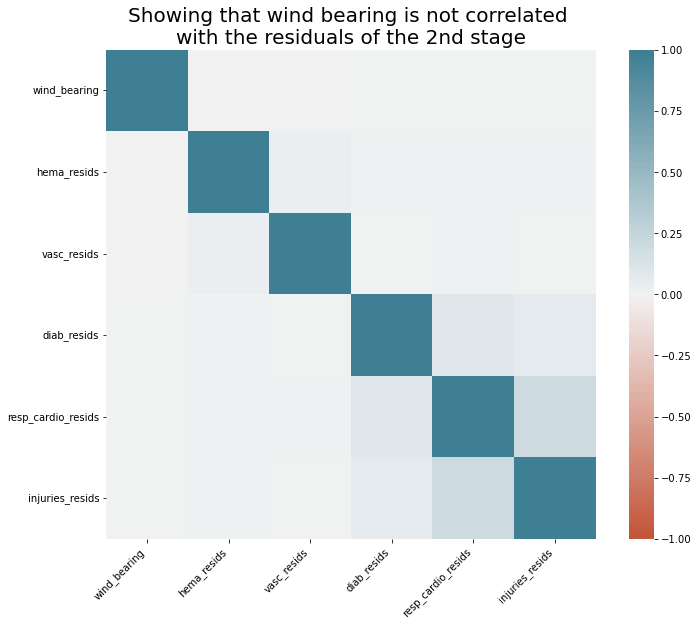

In [68]:
df_corr = pd.DataFrame({
  'wind_bearing': df_model[predictor_name_s1].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [69]:
# get data into right model form
y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_model, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_model, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,259675.0,4.912570e+06,0.0,NaN,NaN,NaN
1,259674.0,4.890261e+06,1.0,22308.277301,1184.574665,5.291622e-259


# Distribution Plots
- These are not yet updated with the additional two diagnosis groups

The disease distributions all on one plot are too hard to visualize.

In [ ]:
df_melt = pd.melt(df, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

The plot of each disease individually is too hard to see also due to inflated 0's.

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Distribution", size=20)
print('')

Each disease distribution is heavily skewed left, with most values very close to 0. 

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Positive Distribution", size=20)
print('')

Plotting the log of each disease distribution, looking at positive cases only is much easier to visualize:

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Vasculitis Positive Distribution (Log)", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Type 1 Diabetes Positive Distribution (Log)", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_resp_cardio']>0], x="y_resp_cardio", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Cardiorespiratory Diseases Positive Distribution (Log)", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_injuries']>0], x="y_injuries", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Injuries (control) Positive Distribution (Log)", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_model, x=target_name_s1, bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_model, x="yhat_pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Predicted Distribution", size=20)
print('')

In [ ]:
df_melt = pd.melt(df_model, 
              value_vars=[target_name_s1, 'yhat_pm25'], 
              var_name='measure', value_name='PM25')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="PM25", hue='measure', bw_adjust=.8, fill=True)\
  .set_title("True PM2.5 (Blue) vs Predicted PM2.5 (Orange)", size=20)
print('')

In [ ]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_model, x=predictor_name_s1, bw_adjust=.8, fill=True)\
  .set_title("Wind Alignment Cosine Distribution", size=20)
print('')